In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

### Data Cleaning and Exploratory Analysis

In [2]:
# Obtaining data from Yahoo Finance
df = yf.download('BTC-USD')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.shape

(3485, 6)

In [4]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
# Selecting the data from the last 5 years
actual_date = df.index[-1]
last_5_years = actual_date  - pd.DateOffset(years=5)
df = df[df.index >= last_5_years]

In [6]:
# Checking if there are NaN values in the DataFrame for each column
df_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume']

for column in df_columns:
    has_nan = df[column].isna().any()
    if has_nan:
        print("The column", column, "has NaN values")
    else:
        print("The column", column, "has no NaN values")

The column Open has no NaN values
The column High has no NaN values
The column Low has no NaN values
The column Close has no NaN values
The column Adj Close has no NaN values
The column Volume has no NaN values


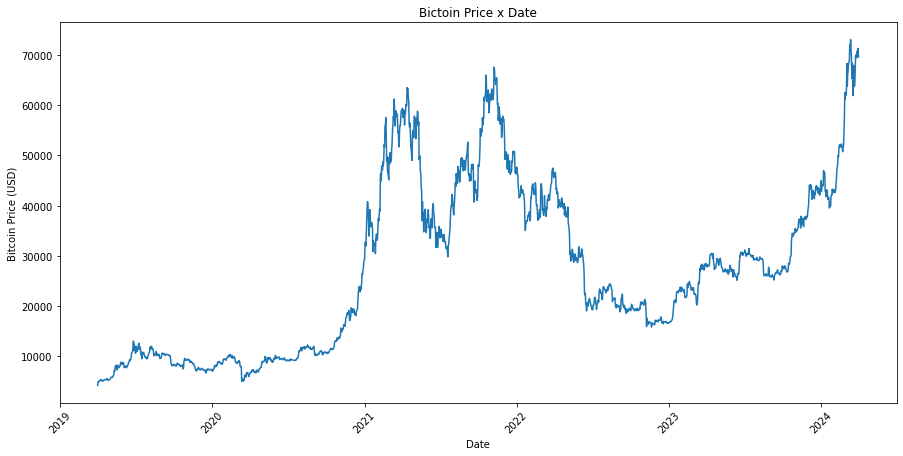

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'])

plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bictoin Price x Date')

plt.xticks(rotation=45)

plt.show()

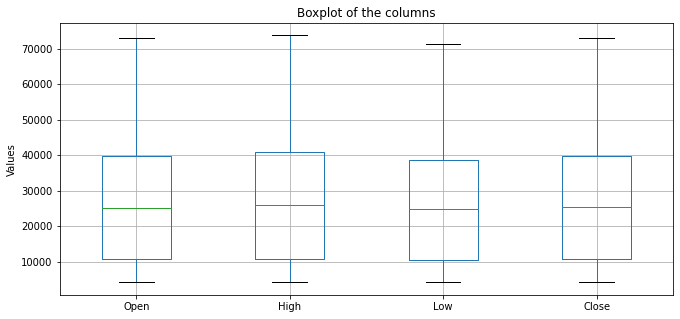

In [8]:
# Checking for the presence of outliers in the data
plt.figure(figsize=(11, 5))
df.iloc[:, :-2].boxplot()
plt.title('Boxplot of the columns')
plt.ylabel('Values')
plt.show()

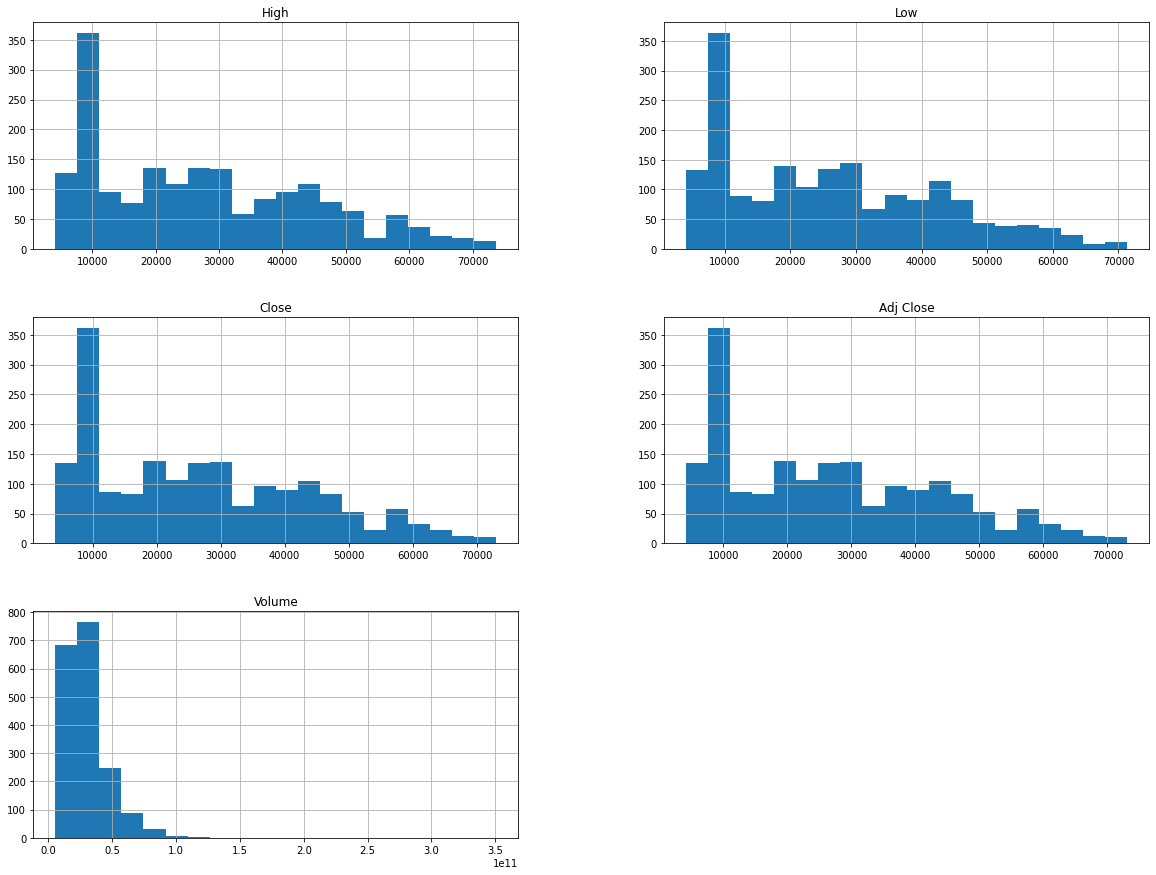

In [9]:
# Plotting the distributions of the DataFrame columns
df.iloc[:, 1:].hist(figsize=(20, 15), bins=20)

plt.show()

In [10]:
# Basic statistics of the DataFrame
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03
mean,27051.460475,27672.220725,26399.482026,27085.114115,27085.114115,3.035813e+10
std,16697.972072,17128.650346,16222.681457,16715.491368,16715.491368,1.794039e+10
min,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,5.331173e+09
25%,10568.935547,10772.513428,10304.507568,10575.864258,10575.864258,1.837205e+10
50%,25141.166016,25937.496094,24849.660156,25369.524414,25369.524414,2.656463e+10
75%,39740.170898,40729.857422,38716.157227,39754.084961,39754.084961,3.725016e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


### Generating the Technical Indicators for the model

##### Overlap Functions

In [11]:
upperband, middleband, lowerband = ta.BBANDS(df['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

In [12]:
ema = ta.EMA(df['Close'], timeperiod=10)

In [13]:
sma = ta.SMA(df['Close'], timeperiod=10)

In [14]:
tema = ta.TEMA(df['Close'], timeperiod=10)

In [15]:
wma = ta.WMA(df['Close'], timeperiod=10)

##### Momentum Functions

In [16]:
adx = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=5)

In [17]:
adxr = ta.ADXR(df['High'], df['Low'], df['Close'], timeperiod=10)

In [18]:
cci = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=10)

In [19]:
macd, macdsignal, macdhist = ta.MACD(df['Close'], fastperiod=5, slowperiod=10, signalperiod=5)

In [20]:
mom = ta.MOM(df['Close'], timeperiod=10)

In [21]:
roc = ta.ROC(df['Close'], timeperiod=10)

In [22]:
rsi = ta.RSI(df['Close'], timeperiod=10)

In [23]:
slowk, slowd = ta.STOCH(df['High'], df['Low'], df['Close'], fastk_period=5, slowk_period=10, slowk_matype=0, slowd_period=10, slowd_matype=0)

In [24]:
willr = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=10)

##### Volume Functions

In [25]:
adosc = ta.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'], fastperiod=5, slowperiod=10)

In [26]:
obv = ta.OBV(df['Close'], df['Volume'])

##### Volatility Functions

In [27]:
atr = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=10)

In [28]:
trange = ta.TRANGE(df['High'], df['Low'], df['Close'])

In [29]:
# Function to create the technical indicators
def generate_technical_indicators(dataset):
    dataset['upperband'], dataset['middleband'], dataset['lowerband'] = ta.BBANDS(dataset['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    dataset['ema'] = ta.EMA(dataset['Close'], timeperiod=10)
    dataset['sma'] = ta.SMA(dataset['Close'], timeperiod=10)
    dataset['tema'] = ta.TEMA(dataset['Close'], timeperiod=10)
    dataset['wma'] = ta.WMA(dataset['Close'], timeperiod=10)
    dataset['adx'] = ta.ADX(dataset['High'], dataset['Low'], dataset['Close'], timeperiod=5)
    dataset['adxr'] = ta.ADXR(dataset['High'], dataset['Low'], dataset['Close'], timeperiod=10)
    dataset['cci'] = ta.CCI(dataset['High'], dataset['Low'], dataset['Close'], timeperiod=10)
    dataset['macd'], dataset['macdsignal'], dataset['macdhist'] = ta.MACD(dataset['Close'], fastperiod=5, slowperiod=10, signalperiod=5)
    dataset['mom'] = ta.MOM(dataset['Close'], timeperiod=10)
    dataset['roc'] = ta.ROC(dataset['Close'], timeperiod=10)
    dataset['rsi'] = ta.RSI(dataset['Close'], timeperiod=10)
    dataset['slowk'], dataset['slowd'] = ta.STOCH(dataset['High'], dataset['Low'], dataset['Close'], fastk_period=5, slowk_period=10, slowk_matype=0, slowd_period=10, slowd_matype=0)
    dataset['willr'] = ta.WILLR(dataset['High'], dataset['Low'], dataset['Close'], timeperiod=10)
    dataset['adosc'] = ta.ADOSC(dataset['High'], dataset['Low'], dataset['Close'], dataset['Volume'], fastperiod=5, slowperiod=10)
    dataset['obv'] = ta.OBV(dataset['Close'], dataset['Volume'])
    dataset['atr'] = ta.ATR(dataset['High'], dataset['Low'], dataset['Close'], timeperiod=10)
    dataset['trange'] = ta.TRANGE(dataset['High'], dataset['Low'], dataset['Close'])

    dataset = dataset.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

    # Formatting the data to match the model's training format
    close_column = dataset.pop('Close')
    dataset['Close'] = close_column

    return dataset

### Implementing the Deep Learning model

In [30]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    df = generate_technical_indicators(df)

In [31]:
df

,upperband,middleband,lowerband,ema,sma,tema,wma,adx,adxr,cci,...,roc,rsi,slowk,slowd,willr,adosc,obv,atr,trange,Close
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.015779e+10,NaN,NaN,4158.183105
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.147284e+10,NaN,750.637695,4879.877930
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.437273e+10,NaN,430.382324,4973.021973
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.612092e+10,NaN,226.365723,4922.798828
2019-04-05,5438.578408,4794.112598,4149.646788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.295825e+10,NaN,134.018066,5036.681152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,71864.787147,69476.223437,67087.659728,68338.362947,67053.991797,69846.922567,68276.497869,31.775692,34.062767,96.658700,...,4.731941,60.154962,63.686409,51.121436,-8.999480,3.086639e+09,1.515061e+12,3799.016247,2650.515625,70744.953125
2024-03-29,70839.637026,70007.954687,69176.272349,68620.992980,67851.997266,70113.401984,68792.649929,26.918492,32.236169,67.403310,...,12.889189,57.363544,69.884762,52.708826,-16.802892,2.634848e+09,1.489830e+12,3602.758372,1836.437500,69892.828125
2024-03-30,70828.004291,69945.253125,69062.501959,68807.231472,68025.160547,70138.144836,69118.705824,23.032732,30.551980,53.877702,...,2.549756,56.517089,65.969200,53.988525,-22.218443,-6.234677e+07,1.472700e+12,3317.925504,754.429688,69645.304688


In [32]:
# Replacing NaN values with zero in the DataFrame
df.fillna(0, inplace=True)

In [33]:
df.isna().any()

upperband     False
middleband    False
lowerband     False
ema           False
sma           False
tema          False
wma           False
adx           False
adxr          False
cci           False
macd          False
macdsignal    False
macdhist      False
mom           False
roc           False
rsi           False
slowk         False
slowd         False
willr         False
adosc         False
obv           False
atr           False
trange        False
Close         False
dtype: bool

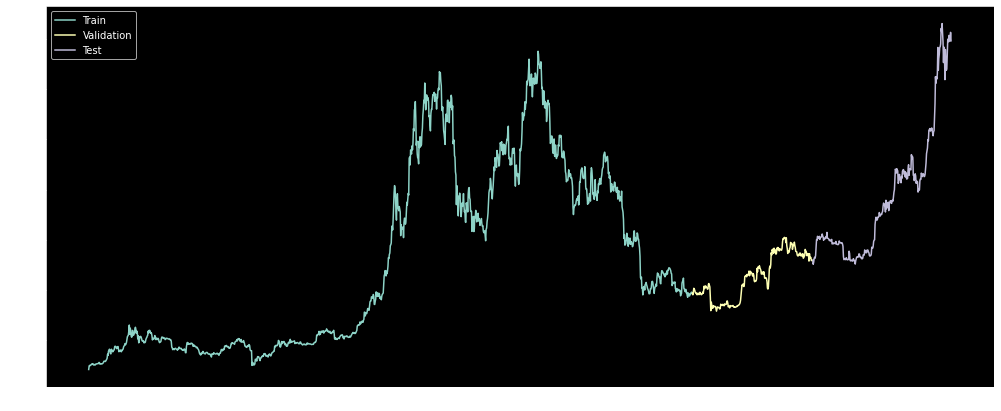

In [34]:
# Plotting the train data, validation data and test data of the model
dates = df.index
train_data = int(len(dates) * .7)
val_data = int((train_data * .2) + train_data) # 20% of the train data

dates_train, y_train = dates[:train_data], df.iloc[:train_data, -1]
dates_val, y_val = dates[train_data:val_data], df.iloc[train_data:val_data, -1]
dates_test, y_test = dates[val_data:], df.iloc[val_data:, -1]

plt.figure(figsize=(17, 7))
plt.style.use('dark_background')
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [35]:
# Normalization of the data in the range of [0, 1] to have a better performance of the algorithm
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = df.copy()

# Normalization of each column independently
for column in scaled_data.columns:
    
    column_data = scaled_data[[column]]
    
    scaled_column = scaler.fit_transform(column_data)
    
    scaled_data[column] = scaled_column.flatten()

# Verifying the normalized DataFrame
scaled_data = scaled_data.values
scaled_data.shape

(1828, 24)

In [36]:
# Preparing the data for the model
n = 2  # Number of days before of the model tries to predict the next price value
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        row = [r for r in data[i:i + n_steps]]  # Selecting all the data of the row to learn to predict the next price value
        X.append(row)
        label = data[i + n_steps][-1]  # Value of the price that the model will predict
        y.append(label)
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data, n)
X.shape, y.shape

((1826, 2, 24), (1826,))

In [37]:
# Selecting the train data, validation data and test data
train_data = int(len(X) * .7)
val_data = int((train_data * .2) + train_data)

X_train, X_val, X_test = X[:train_data], X[train_data:val_data], X[val_data:]
y_train, y_val, y_test = y[:train_data], y[train_data:val_data], y[val_data:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1278, 2, 24), (1278,), (255, 2, 24), (255,), (293, 2, 24), (293,))

In [38]:
# Building the LSTM model
model = Sequential([
    LSTM(200, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.summary()

c:\Users\celio\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       180,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,201 (703.91 KB)

 Trainable params: 180,201 (703.91 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
optimizer = Adam(beta_1=0.9, beta_2=0.999, learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0571 - val_loss: 8.3846e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 3.8125e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3106e-04 - val_loss: 3.4261e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4828e-04 - val_loss: 3.4581e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7401e-04 - val_loss: 2.6871e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2398e-04 - val_loss: 3.9036e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6109e-04 - val_loss: 2.9142e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2381e-04 - val_loss: 1.8840e-04
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3156e-04 - val_loss: 1.9974e-04
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0815e-04 - val_loss: 2.7745e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0880e-04 - val_loss: 1.4

In [40]:
# Making predictions of the test data
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [41]:
predictions.shape

(293, 1)

#### Evaluating the model

In [42]:
print(17*'=', ' Error Metrics ', 17*'=')
print('Mean Absolute Error: ', mean_absolute_error(y_test, predictions).round(4))
print(51*'-')
print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(y_test, predictions).round(4))
print(51*'-')
print('Mean Squared Error: ', mean_squared_error(y_test, predictions).round(4))
print(51*'-')
print('Root Mean Squared Error: ', mean_squared_error(y_test, predictions, squared=False).round(4))
print(51*'=')
print('R^2: ', r2_score(y_test, predictions).round(4))
print(51*'=')

=================  Error Metrics  =================
Mean Absolute Error:  0.0123
---------------------------------------------------
Mean Absolute Percentage Error:  0.0237
---------------------------------------------------
Mean Squared Error:  0.0003
---------------------------------------------------
Root Mean Squared Error:  0.0182
R^2:  0.9904


In [43]:
# Undoing the normalization of predictions and real valuess
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

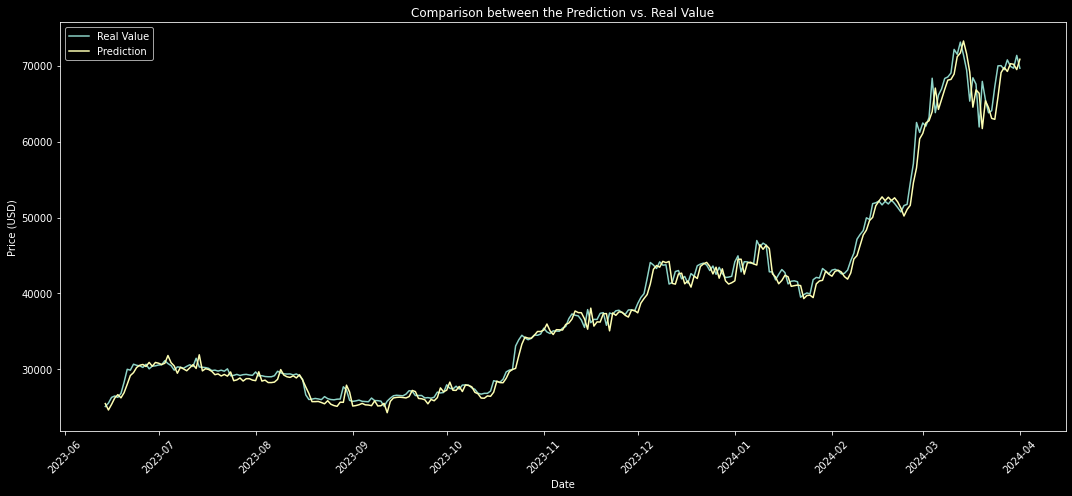

In [44]:
# Getting the dates corresponding to the test set
test_dates = df.index[val_data+n:]

# Plotting the comparison between the real values and predict values
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test[:, -1], label='Real Value')
plt.plot(test_dates, predictions[:, -1], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Comparison between the Prediction vs. Real Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Creating flexible code to apply to new data

In [45]:
# Informations to change and then just run all the code
ticker = 'BTC-USD' # Company where the data will be collected
ndays = 365 # Number of days to pull the historical data
ndays_to_predict = 1 # Number of days to make a prediction

In [46]:
def get_data():
    # Obtaining data from Yahoo Finance
    data = yf.download(ticker, start=pd.Timestamp.now() - pd.Timedelta(days=ndays), end=pd.Timestamp.now())
    
    return data

# Loading the chosen data
data = get_data()

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-02,28462.845703,28518.958984,27884.087891,28199.308594,28199.308594,12284641999
2023-04-03,28183.080078,28475.623047,27276.720703,27790.220703,27790.220703,19556501327
2023-04-04,27795.273438,28433.742188,27681.304688,28168.089844,28168.089844,15284538859
2023-04-05,28169.726562,28739.238281,27843.763672,28177.984375,28177.984375,17052315986
2023-04-06,28175.226562,28178.384766,27738.759766,28044.140625,28044.140625,13837809380
...,...,...,...,...,...,...
2024-03-28,69452.773438,71546.023438,68895.507812,70744.953125,70744.953125,34374900617
2024-03-29,70744.796875,70913.093750,69076.656250,69892.828125,69892.828125,25230851763
2024-03-30,69893.445312,70355.492188,69601.062500,69645.304688,69645.304688,17130241883


In [47]:
data = generate_technical_indicators(data)

data.fillna(0, inplace=True)

In [48]:
data

,upperband,middleband,lowerband,ema,sma,tema,wma,adx,adxr,cci,...,roc,rsi,slowk,slowd,willr,adosc,obv,atr,trange,Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.228464e+10,0.000000,0.000000,28199.308594
2023-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-7.271859e+09,0.000000,1198.902344,27790.220703
2023-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.012680e+09,0.000000,752.437500,28168.089844
2023-04-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.506500e+10,0.000000,895.474609,28177.984375
2023-04-06,28381.590677,28075.948828,27770.306979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.122719e+10,0.000000,439.625000,28044.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,71864.787147,69476.223437,67087.659728,68338.362947,67053.991797,69846.922567,68276.497869,31.775692,34.062767,96.658700,...,4.731941,60.154962,63.686409,51.121436,-8.999480,3.086639e+09,6.077415e+11,3799.016247,2650.515625,70744.953125
2024-03-29,70839.637026,70007.954687,69176.272349,68620.992980,67851.997266,70113.401984,68792.649929,26.918492,32.236169,67.403310,...,12.889189,57.363544,69.884762,52.708826,-16.802892,2.634848e+09,5.825107e+11,3602.758372,1836.437500,69892.828125
2024-03-30,70828.004291,69945.253125,69062.501959,68807.231472,68025.160547,70138.144836,69118.705824,23.032732,30.551980,53.877702,...,2.549756,56.517089,65.969200,53.988525,-22.218443,-6.234677e+07,5.653804e+11,3317.925504,754.429688,69645.304688


In [49]:
# Creating a MinMaxScaler and Normalization function
scaler = MinMaxScaler(feature_range=(0, 1))

def normalization_data(dataset, ndays_to_predict=1):

    n = 2 # Timesteps fixed to build the model
    
    scaled_data = dataset.iloc[-n-ndays_to_predict:, :].copy()

    for column in scaled_data.columns:
    
        column_data = scaled_data[[column]]
        
        scaled_column = scaler.fit_transform(column_data)
        
        scaled_data[column] = scaled_column.flatten()

    scaled_data = scaled_data.values

    return scaled_data

In [50]:
scaled_data = normalization_data(data, ndays_to_predict)
scaled_data.shape

(3, 24)

In [51]:
# Preparing the data for the model
n = 2  # Number of days before the model tries to predict the next price value
def prepare_data(data, n_steps):
    X = []
    for i in range(n_steps, len(data)):
        row = [r for r in data[(i - n_steps) + 1:i + 1]]
        X.append(row)
    return np.array(X)

X = prepare_data(scaled_data, n)
X.shape

(1, 2, 24)

In [52]:
predictions = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [53]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
predictions

array([[70556.69]], dtype=float32)

In [54]:
def plot_predictions(dataset, predictions, ndays_to_predict):
    # Criar um índice para os próximos 14 dias
    next_n_days = pd.date_range(start=dataset.index[-1] + pd.Timedelta(days=1), periods=ndays_to_predict)

    # # Criar uma série temporal para os valores reais e previstos
    real_values = dataset['Close'][-ndays_to_predict-5:]
    # predictions = np.reshape(predictions, -1)
    predicted_values = pd.Series(predictions.flatten(), index=next_n_days)

    last_value = real_values.iloc[-1]
    predicted_values = pd.concat([pd.Series([last_value], index=[predicted_values.index[0] - pd.Timedelta(days=1)]), predicted_values])

    # Plotar os valores reais e previstos
    plt.figure(figsize=(17, 8))
    plt.plot(real_values.index, real_values.values, label='Real Values')
    plt.plot(predicted_values.index, predicted_values.values, label='Predicted Value', marker='o')

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price of the ' + ticker)
    plt.title('Prediction of the ' + ticker + ' for the next ' + str(ndays_to_predict) + ' days')
    plt.legend()
    plt.show()

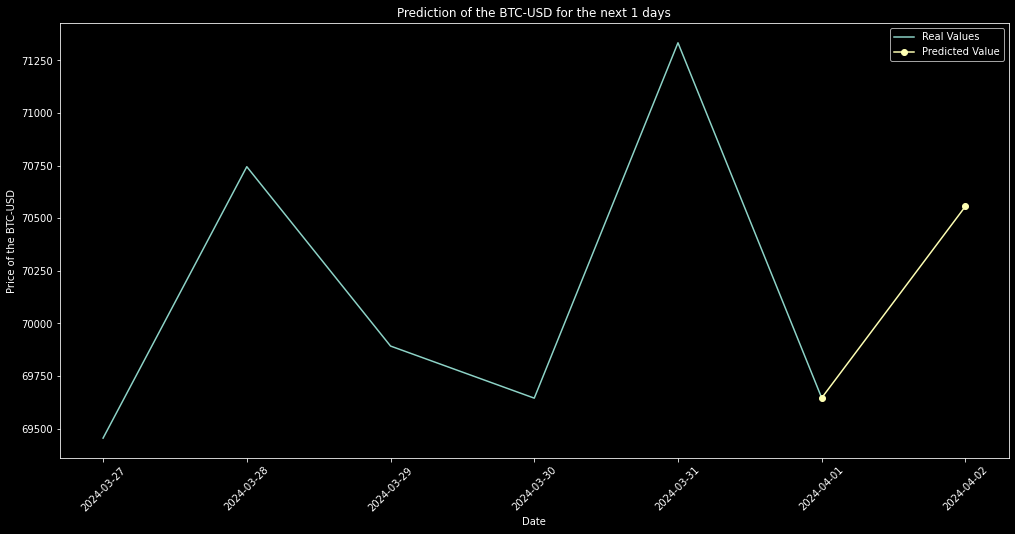

In [55]:
plot_predictions(data, predictions, ndays_to_predict)